In [1]:
import tensorflow as tf
from BNN import BNN
from preprocess_data import read_data
import numpy as np
from sklearn.utils import shuffle
from utils import *
import matplotlib.pyplot as plt

In [2]:
# Set the seed
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

# Load data
data_file = 'vmro3_refC1SD_70x36_13mdls_masked_extrap_and_interp.pkl'
X_train, y_train, X_test, y_test, X_interp, y_interp, X_extrap, y_extrap, X_at, y_at = read_data(data_file)

Number of obs: 439203
Training on 83.1%
Testing on 4.4%
Validation (temporal extrapolation) on 6.8%
Validation (interpolation) on 5.7%


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

num_NNs = 20
checkpoint_dir = './checkpoints/model{}/'
log_dir = './logs/model{}/'
x_dim = X_train.shape[1]
y_dim = y_train.shape[1]
num_models = 13
n_data = X_train.shape[0]
hidden_size = 500
learning_rate = 0.0001

# Priors 
bias_mean = 0.00
bias_std = 0.02
noise_mean = 0.03
noise_std = 0.02
layer_scale = 1.1

alpha_dim = x_dim - num_models
init_std_1w =  np.sqrt(150.0/(alpha_dim))
init_std_1b = init_std_1w
init_std_2w =  (layer_scale)/np.sqrt(hidden_size)
init_std_2b = init_std_2w
init_std_biasw = (1.05 * layer_scale * bias_std)/np.sqrt(hidden_size)
init_std_noisew = (2.5)/np.sqrt(hidden_size)
lambda_anchor = 1.0/(np.array([init_std_1w,init_std_1b,init_std_2w,init_std_2b,init_std_biasw,init_std_noisew])**2)

In [4]:
# Build the NNs within the ensemble
NNs = []
for i in range(num_NNs):
    NNs.append(BNN(sess, checkpoint_dir.format(i),
                   log_dir.format(i),
                   x_dim, y_dim, num_models, n_data,
                   hidden_size, learning_rate, lambda_anchor, 
                   init_std_1w, init_std_1b, init_std_2w,
                   init_std_2b, init_std_biasw, init_std_noisew))











Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model
Reading checkpoints...
Initialising new model


Prior checks

In [5]:
# Randomise the training data - 100000 points
n_prior_points = 100000

X_train, y_train = shuffle(X_train, y_train)
X_prior = X_train[:n_prior_points]

We want the standard deviation of the presoftmax layer to be ~1 as this ensures that our prior is that at any point any model combination is equally likely. Though this prior becomes the multi model mean when we average across the NNs in the ensemble

1.0085619132143706


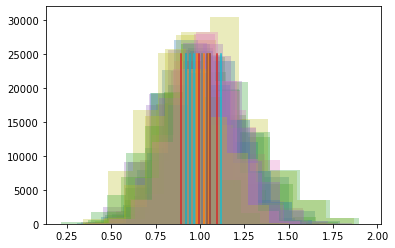

In [6]:
stds = get_pre_softmax_stds(NNs, X_prior)
print(np.mean(stds))
for i in range(len(NNs)):
    plt.hist(stds[:, i], alpha=0.3)
    plt.plot([np.mean(stds[:, i]), np.mean(stds[:, i])], [0, n_prior_points / 4])
plt.show()    

In [7]:
alphas = get_weights(NNs, X_prior)
alpha = np.mean(alphas, axis=-1)

print('Alpha mean should be: {}'.format(1/num_models))
print('Alpha mean is: {}'.format(np.mean(alphas)))
print('Alpha std should be: {}'.format(np.sqrt((1/(1 + num_models)) * (1/num_models)*(1-(1/num_models)))))
print('Alpha std is: {}'.format(np.mean(np.std(alphas, axis=2))))

Alpha mean should be: 0.07692307692307693
Alpha mean is: 0.07692307692602679
Alpha std should be: 0.07121693075173474
Alpha std is: 0.07625856804143444


In [8]:
beta = get_bias(NNs, X_prior)
print('Beta mean should be: {}'.format(bias_mean))
print('Beta mean is: {}'.format(np.mean(beta)))
print('Beta std should be: {}'.format(bias_std))
print('Beta std is: {}'.format(np.mean(np.std(beta, axis=1))))

Beta mean should be: 0.0
Beta mean is: 0.0030271107554477096
Beta std should be: 0.02
Beta std is: 0.020115897020867274


In [9]:
noise = get_aleatoric_noise(NNs, X_prior)
print('Noise mean should be: {}'.format(noise_mean))
print('Noise mean is: {}'.format(np.mean(noise)))
print('Noise std should be: {}'.format(noise_std))
print('Noise std is: {}'.format(np.mean(np.std(noise, axis=1))))

Noise mean should be: 0.03
Noise mean is: 0.03343835119904624
Noise std should be: 0.02
Noise std is: 0.019850035421631673
